# RF superconducting qubit control 101 - sending pulses to two qubits

In [1]:
#pip install cirq

In [2]:
import sys
# sys.path.append('../../qick/qick_lib/')
sys.path.append('../soft/')
sys.path.append('../firmware/')

from qick import *
from qick_training import *
from qick.averager_program import QickSweep
from qick.averager_program import merge_sweeps
from RBSupport import generate_2qgateset

import numpy as np
from numpy.fft import fft, fftshift
import matplotlib.pyplot as plt
import pickle
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
import matplotlib.ticker as mtick

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
soc = QickSoc()
soccfg = soc

print(soccfg)


QICK configuration:

	Board: ZCU216

	Software version: 0.2.179
	Firmware timestamp: Thu Feb 17 16:46:52 2022

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v4 - tProc output 1, envelope memory 65536 samples
		DAC tile 2, blk 0, 32-bit DDS, fabric=430.080 MHz, f_dds=6881.280 MHz
	1:	axis_signal_gen_v4 - tProc output 2, envelope memory 65536 samples
		DAC tile 2, blk 1, 32-bit DDS, fabric=430.080 MHz, f_dds=6881.280 MHz
	2:	axis_signal_gen_v4 - tProc output 3, envelope memory 65536 samples
		DAC tile 2, blk 2, 32-bit DDS, fabric=430.080 MHz, f_dds=6881.280 MHz
	3:	axis_signal_gen_v4 - tProc output 4, envelope memory 65536 samples
		DAC tile 2, blk 3, 32-bit DDS, fabric=430.080 MHz, f_dds=6881.280 MHz
	4:	axis_signal_gen_v4 - tProc output 5, envelope memory 65536 samples
		DAC tile 3, blk 0, 32-bit DDS, fabric=430.080 MHz, f_dds=6881.280 MHz
	5:	axis_signal_gen_v4 - tProc output 6, envelope memory 65536 samples
		DAC ti

In [4]:
class PulseSequence(AveragerProgram):
    def initialize_phases(self):
        ## Prepare state
        self.phase_ref_q1 = 0
        self.phase_ref_q2 = 0
        self.phase_ref_c = 0
    
    def play_seq(self, seq):
        for g in seq:
            for q in g:
                if q == "Q2":
                    ginfo=self.cfg["gate_set"][g[q]]
                    if g[q]=="Z":
                        self.phase_ref_q2+=180
                    elif g[q]=="Z/2":
                        self.phase_ref_q2+=90
                    elif g[q]=="-Z/2":
                        self.phase_ref_q2+=-90
                    else:
                        self.set_pulse_registers(ch=self.cfg["q2_ch"], freq=self.freq_q2,
                                                 phase=self.deg2reg(self.phase_ref_q2 + ginfo["phase"], gen_ch=self.cfg["q2_ch"]),
                                                 gain=ginfo["gain"], waveform=g[q], phrst=0,mode="oneshot")
                        self.pulse(ch=self.cfg["q2_ch"])
                if q == "Q1": # Qubit 1
                    ginfo=self.cfg["gate_set"][g[q]]
                    """For the Z gates (virtual rotation), we need to advance the phase of all the pulses which follows afterwards"""
                    if g[q]=="Z":
                        self.phase_ref_q1+=180
                    elif g[q]=="Z/2":
                        self.phase_ref_q1+=90
                    elif g[q]=="-Z/2":
                        self.phase_ref_q1+=-90
                    else:
                        self.set_pulse_registers(ch=self.cfg["q1_ch"], freq=self.freq_q1,
                                                 phase=self.deg2reg(self.phase_ref_q1 + ginfo["phase"], gen_ch=self.cfg["q1_ch"]),
                                                 gain=ginfo["gain"], waveform=g[q], phrst=0,mode="oneshot")
                        self.pulse(ch=self.cfg["q1_ch"])
            ################
           #modified sync_all with only DAC clocks, no ADC clocks
            self.synci(self.us2cycles(0.01))
    
    def initialize(self):
        cfg = self.cfg
        self.gate_seq = cfg['gate_seq']
        self.gate_set = cfg['gate_set']
        # set the nyquist zone
        self.declare_gen(ch=cfg["q1_ch"], nqz=1)
        self.declare_gen(ch=cfg["q2_ch"], nqz=1)

        for ch in cfg["ro_chs"]:
            self.declare_readout(ch=ch, length=cfg["readout_length"],
                                 freq=cfg["q" + str(ch + 1) +"_read_freq"], 
                                 gen_ch=cfg["q" + str(ch + 1) +"_ch"])
            
        # convert frequency to DAC frequency (ensuring it is an available ADC frequency)
        self.freq_q1 = self.freq2reg(cfg["q1_pulse_freq"], gen_ch=cfg["q1_ch"], ro_ch=cfg["q1_ro_ch"])
        self.freq_q2 = self.freq2reg(cfg["q2_pulse_freq"], gen_ch=cfg["q2_ch"], ro_ch=cfg["q2_ro_ch"])

        for name, ginfo in self.gate_set.items():
            self.add_pulse(ch=cfg["q1_ch"], name=name,
                           idata=ginfo["idata"],
                           qdata=ginfo["qdata"],
                          )
            self.add_pulse(ch=cfg["q2_ch"], name=name,
                           idata=ginfo["idata"],
                           qdata=ginfo["qdata"],
                          )

        self.default_pulse_registers(ch=cfg["q1_ch"], style="arb")
        self.default_pulse_registers(ch=cfg["q2_ch"], style="arb")

        self.synci(1000)  # give processor some time to configure pulses

    def body(self):
        ## Trigger measurement
        self.trigger(adcs=self.ro_chs,
                     pins=[0],
                     adc_trig_offset=self.cfg["adc_trig_offset"])

        self.initialize_phases()
        self.play_seq(self.gate_seq)
        self.wait_all()
        self.sync_all(self.us2cycles(self.cfg["relax_delay"]))

In [5]:
# Plot function

def plot_2q(iq_lists):
    for n in range(0, len(iq_lists)):
        fig, axs = plt.subplots(len(iq_lists[n]),dpi=200)
        for ii, iq in enumerate(iq_lists[n]):
            axs[ii].set_title("Qubit %d" % (config['ro_chs'][ii]+1))
            axs[ii].plot(1000*soc.cycles2us(np.arange(0,len(iq[0])),ro_ch=config['ro_chs'][ii]
                                                                ),iq[0], label="I value, ADC %d" % (config['ro_chs'][ii]))
            axs[ii].plot(1000*soc.cycles2us(np.arange(0,len(iq[0])),ro_ch=config['ro_chs'][ii]
                                                                ),iq[1], label="Q value, ADC %d" % (config['ro_chs'][ii]))
            axs[ii].plot(1000*soc.cycles2us(np.arange(0,len(iq[0])),ro_ch=config['ro_chs'][ii]
                                                                ),np.abs(iq[0] + 1j * iq[1]), label="mag, ADC %d" % (config['ro_chs'][ii]))
            axs[ii].legend(loc=1, prop={'size': 6})
            axs[ii].set_ylabel("a.u.")
            axs[ii].xaxis.set_major_locator(MultipleLocator(1000*5*soc.cycles2us(4, gen_ch = 0)))
            axs[ii].grid(which='major', color='#CCCCCC', linestyle='--')
            axs[ii].xaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
            axs[ii].tick_params(axis='x', rotation=45)

        plt.xlabel('ns')
        plt.tight_layout()

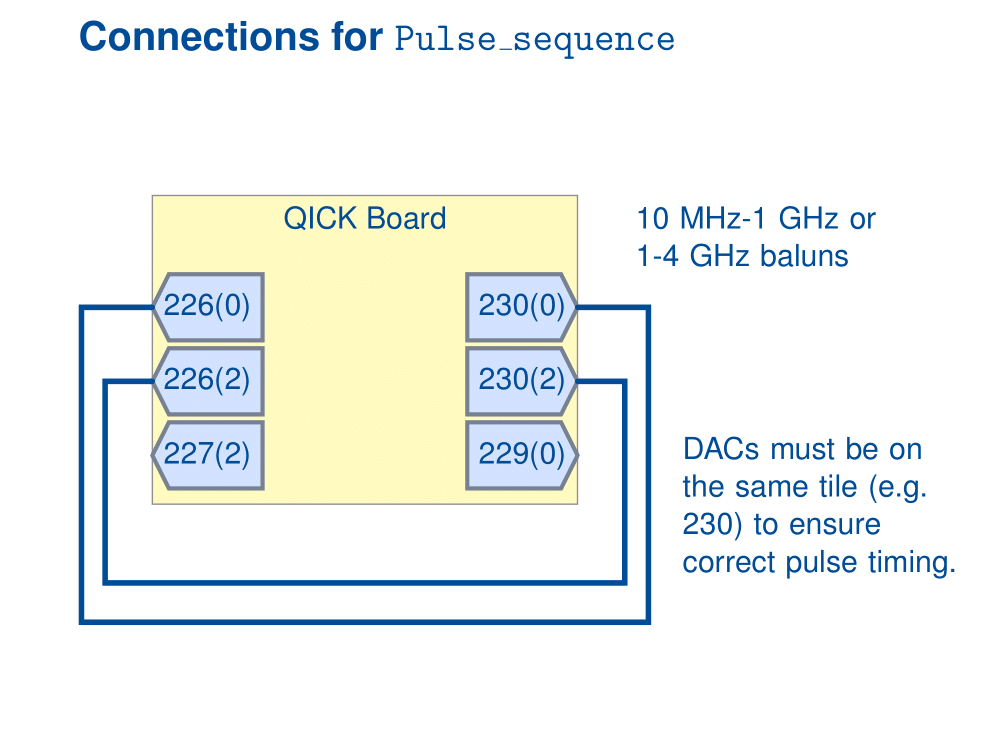

In [6]:
from IPython.display import Image, display
display(Image(filename='images/Connections_Pulse_sequence.png', embed=True))

# RF superconducting qubit control 101: Let's get started!

## Qubits are resonant devices

Qubits are resonant devices: they only respond to on-resonance signals, but avoid exciting other transitions.

Let's drive our qubits with three 2 GHz "X" pi pulses in a row. Since we are also reading in at 2 GHz, we see a fully downconverted "DC" signal.

In [7]:
q1_pulse_freq = 2000 
q1_read_freq = 2000
q2_pulse_freq = 2000 
q2_read_freq = 2000

config = {"q1_ch": 0,  # --Fixed
          "q2_ch": 2,
          "q1_ro_ch": 0,
          "q2_ro_ch": 1,
          "ro_chs": [0,1],
          "reps": 1,  # --Fixed
          "relax_delay": 1.0,  # --us
          "res_phase": 0,  # --degrees
          "pulse_style": "arb",  # --Fixed
          "pi_sigma": soc.us2cycles(0.01,gen_ch=2),
          "readout_length": soc.us2cycles(1,ro_ch=0),  # [Clock ticks]
          "pi_gain": 30000,  # [DAC units]
          "pi_2_gain": 15000,
          "q1_pulse_freq": q1_pulse_freq,  # [MHz]
          "q2_pulse_freq": q2_pulse_freq,  # [MHz]
          "q1_read_freq": q1_read_freq,
          "q2_read_freq": q2_read_freq,
          "adc_trig_offset": soc.us2cycles(0.52,ro_ch=0),  # [Clock ticks]
          "soft_avgs": 1,
          "expts": 1
          }

config["gate_set"] = generate_2qgateset(config)

config['gate_seq'] = [{'Q1': 'X', 'Q2': 'X'}, {'Q1': 'X', 'Q2': 'X'}, {'Q1': 'X', 'Q2': 'X'} ]

print(config['gate_seq'])

[{'Q1': 'X', 'Q2': 'X'}, {'Q1': 'X', 'Q2': 'X'}, {'Q1': 'X', 'Q2': 'X'}]


In [8]:
prog = PulseSequence(soccfg, config)
# print(prog)
iq_lists = []
# print(self.cfg)
soc.reset_gens()  # clear any DC or periodic values on generators
iq_list = prog.acquire_decimated(soc, load_pulses=True, progress=False, debug=False)
iq_lists.append(iq_list)

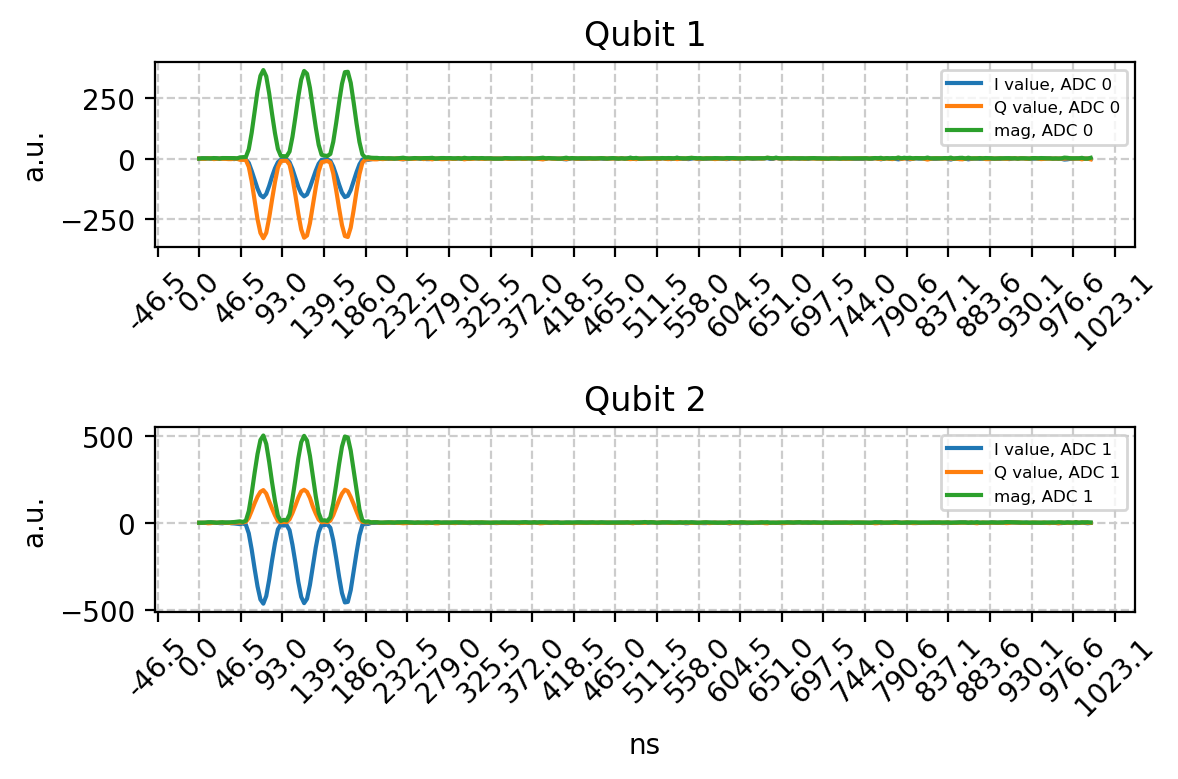

In [9]:
plot_2q(iq_lists)

Let's try reading in at a different frequency. When we do this, we don't "downconvert" the signal fully and end up seeing frequency components in I/Q space. The signal has the same magnitude though. We DON'T want to do this with real qubits as we want to see the undistorted signals in I/Q space. We will talk about this in the next notebook QubitReadout.


In [10]:
q1_pulse_freq = 2000 
q1_read_freq = 2100
q2_pulse_freq = 2000 
q2_read_freq = 2100

config = {"q1_ch": 0,  # --Fixed
          "q2_ch": 2,
          "q1_ro_ch": 0,
          "q2_ro_ch": 1,
          "ro_chs": [0,1],
          "reps": 1,  # --Fixed
          "relax_delay": 1.0,  # --us
          "res_phase": 0,  # --degrees
          "pulse_style": "arb",  # --Fixed
          "pi_sigma": soc.us2cycles(0.01,gen_ch=2),
          "readout_length": soc.us2cycles(1,ro_ch=0),  # [Clock ticks]
          "pi_gain": 30000,  # [DAC units]
          "pi_2_gain": 15000,
          "q1_pulse_freq": q1_pulse_freq,  # [MHz]
          "q2_pulse_freq": q2_pulse_freq,  # [MHz]
          "q1_read_freq": q1_read_freq,
          "q2_read_freq": q2_read_freq,
          "adc_trig_offset": soc.us2cycles(0.52,ro_ch=0),  # [Clock ticks]
          "soft_avgs": 1,
          "expts": 1
          }


config["gate_set"] = generate_2qgateset(config)

config['gate_seq'] = [{'Q1': 'X', 'Q2': 'X'}, {'Q1': 'X', 'Q2': 'X'}, {'Q1': 'X', 'Q2': 'X'} ]

print(config['gate_seq']) 

[{'Q1': 'X', 'Q2': 'X'}, {'Q1': 'X', 'Q2': 'X'}, {'Q1': 'X', 'Q2': 'X'}]


In [11]:
prog = PulseSequence(soccfg, config)
# print(prog)
iq_lists = []
# print(self.cfg)
soc.reset_gens()  # clear any DC or periodic values on generators
iq_list = prog.acquire_decimated(soc, load_pulses=True, progress=False, debug=False)
iq_lists.append(iq_list)

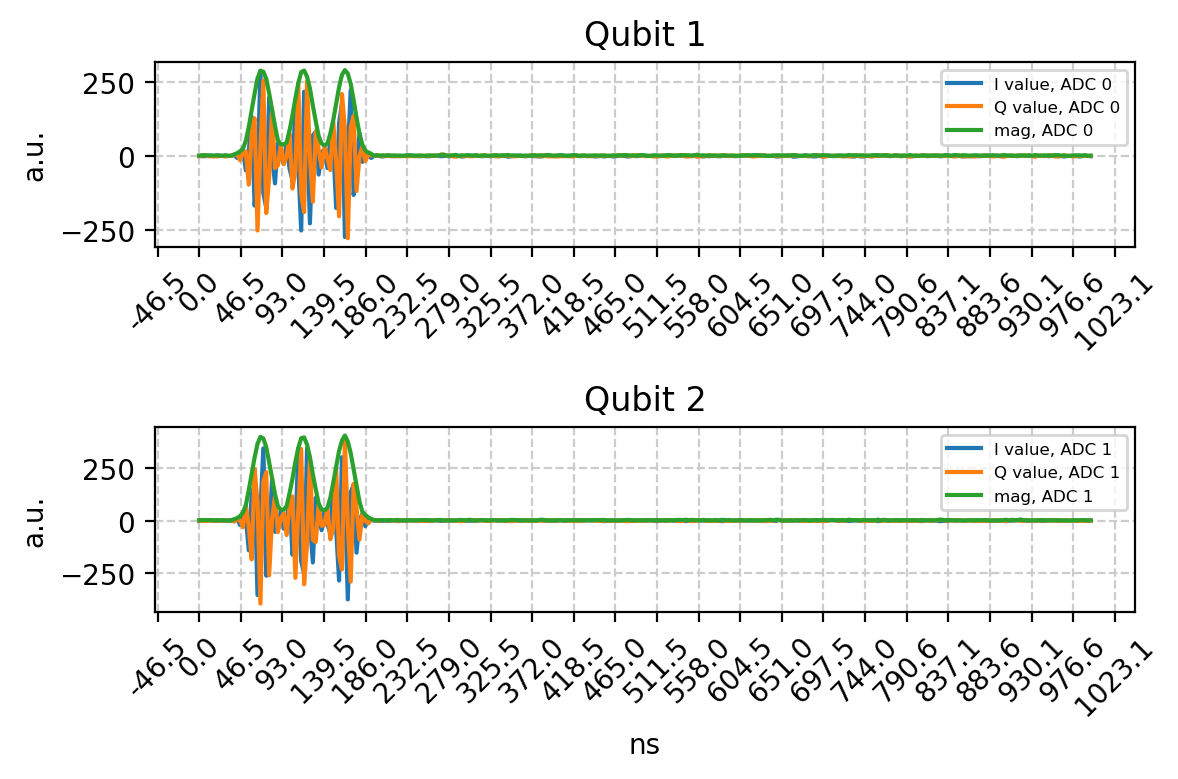

In [12]:
plot_2q(iq_lists)

In general, the qubits are at different frequencies. 

In [13]:
q1_pulse_freq = 2000 
q1_read_freq = 2000
q2_pulse_freq = 2100 
q2_read_freq = 2100

config = {"q1_ch": 0,  # --Fixed
          "q2_ch": 2,
          "q1_ro_ch": 0,
          "q2_ro_ch": 1,
          "ro_chs": [0,1],
          "reps": 1,  # --Fixed
          "relax_delay": 1.0,  # --us
          "res_phase": 0,  # --degrees
          "pulse_style": "arb",  # --Fixed
          "pi_sigma": soc.us2cycles(0.01,gen_ch=2),
          "readout_length": soc.us2cycles(1,ro_ch=0),  # [Clock ticks]
          "pi_gain": 30000,  # [DAC units]
          "pi_2_gain": 15000,
          "q1_pulse_freq": q1_pulse_freq,  # [MHz]
          "q2_pulse_freq": q2_pulse_freq,  # [MHz]
          "q1_read_freq": q1_read_freq,
          "q2_read_freq": q2_read_freq,
          "adc_trig_offset": soc.us2cycles(0.52,ro_ch=0),  # [Clock ticks]
          "soft_avgs": 1,
          "expts": 1
          }


config["gate_set"] = generate_2qgateset(config)

config['gate_seq'] = [{'Q1': 'X', 'Q2': 'X'}, {'Q1': 'X', 'Q2': 'X'}, {'Q1': 'X', 'Q2': 'X'} ]

print(config['gate_seq']) 

[{'Q1': 'X', 'Q2': 'X'}, {'Q1': 'X', 'Q2': 'X'}, {'Q1': 'X', 'Q2': 'X'}]


In [14]:
prog = PulseSequence(soccfg, config)
# print(prog)
iq_lists = []
# print(self.cfg)
soc.reset_gens()  # clear any DC or periodic values on generators
iq_list = prog.acquire_decimated(soc, load_pulses=True, progress=False, debug=False)
iq_lists.append(iq_list)

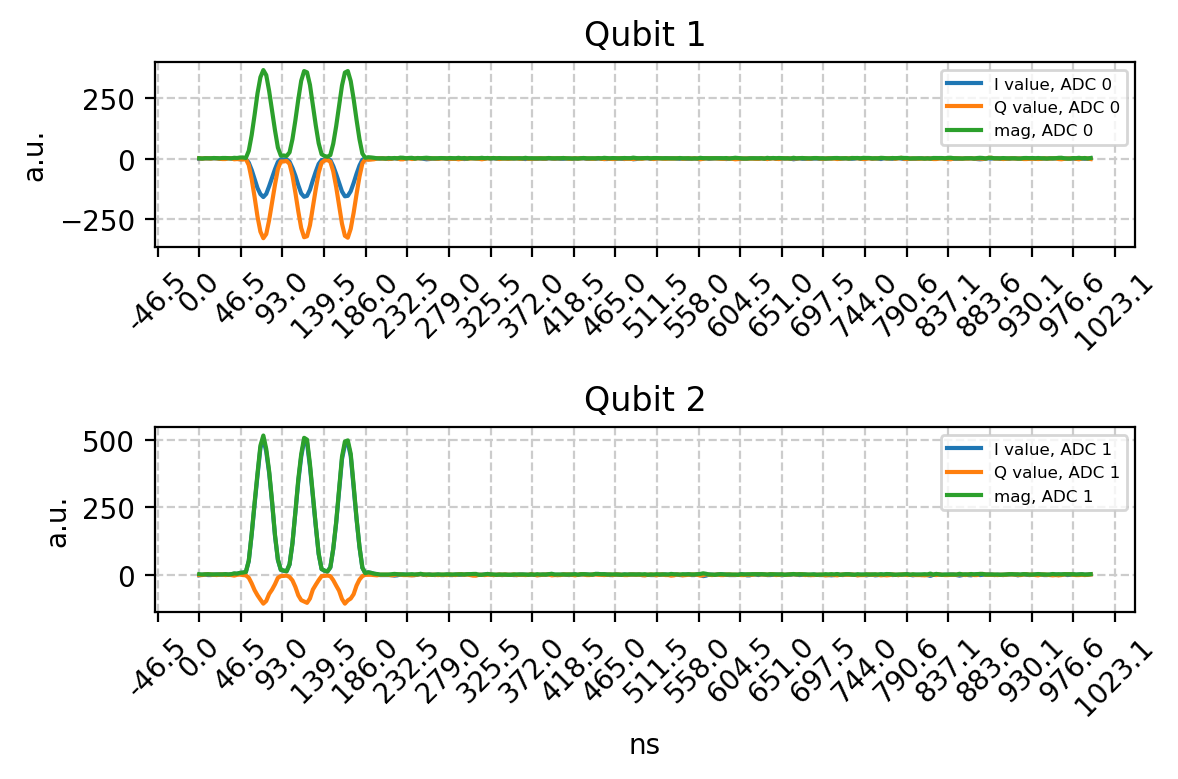

In [15]:
plot_2q(iq_lists)

## Quantum gates are Gaussian wave packets at the resonant frequency

Quantum gates are wave packets at the resonant frequency; you want an envelope that minimizes duration and bandwidth, so the envelope should be Gaussian, not rectangular.

Let's change the width of our Gaussian envelope that we use to drive our qubits.
Our original width is 0.01 us. Let's change that to 0.05 us!


In [16]:
q1_pulse_freq = 2000 
q1_read_freq = 2000
q2_pulse_freq = 2100 
q2_read_freq = 2100
pi_sigma_us = 0.05

config = {"q1_ch": 0,  # --Fixed
          "q2_ch": 2,
          "q1_ro_ch": 0,
          "q2_ro_ch": 1,
          "ro_chs": [0,1],
          "reps": 1,  # --Fixed
          "relax_delay": 1.0,  # --us
          "res_phase": 0,  # --degrees
          "pulse_style": "arb",  # --Fixed
          "pi_sigma": soc.us2cycles(pi_sigma_us,gen_ch=2),
          "readout_length": soc.us2cycles(1,ro_ch=0),  # [Clock ticks]
          "pi_gain": 30000,  # [DAC units]
          "pi_2_gain": 15000,
          "q1_pulse_freq": q1_pulse_freq,  # [MHz]
          "q2_pulse_freq": q2_pulse_freq,  # [MHz]
          "q1_read_freq": q1_read_freq,
          "q2_read_freq": q2_read_freq,
          "adc_trig_offset": soc.us2cycles(0.52,ro_ch=0),  # [Clock ticks]
          "soft_avgs": 1,
          "expts": 1
          }


config["gate_set"] = generate_2qgateset(config)

config['gate_seq'] = [{'Q1': 'X', 'Q2': 'X'}, {'Q1': 'X', 'Q2': 'X'}, {'Q1': 'X', 'Q2': 'X'} ]

print(config['gate_seq'])

[{'Q1': 'X', 'Q2': 'X'}, {'Q1': 'X', 'Q2': 'X'}, {'Q1': 'X', 'Q2': 'X'}]


In [17]:
prog = PulseSequence(soccfg, config)
# print(prog)
iq_lists = []
# print(self.cfg)
soc.reset_gens()  # clear any DC or periodic values on generators
iq_list = prog.acquire_decimated(soc, load_pulses=True, progress=False, debug=False)
iq_lists.append(iq_list)

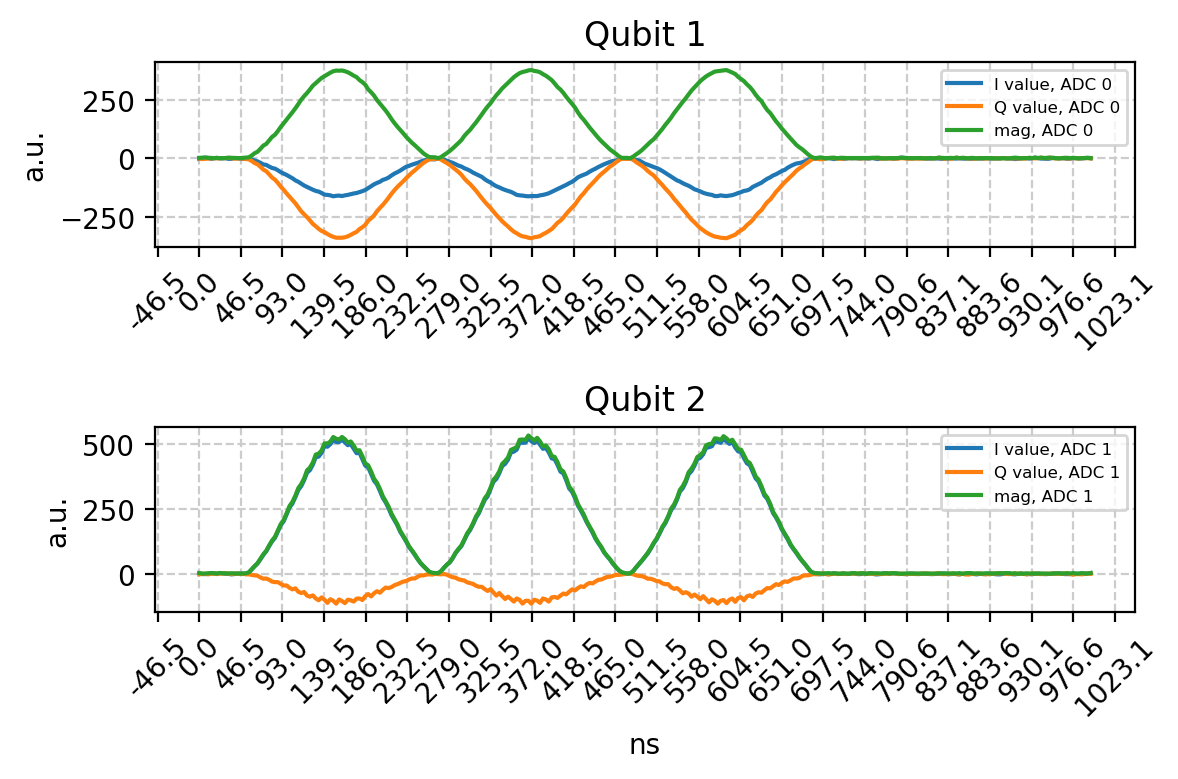

In [18]:
plot_2q(iq_lists)

## The qubit drive pulse phase sets the axis of rotation on the Bloch sphere.

* A X pulse rotates the qubit 180 degrees about the X axis of its Bloch sphere.
* A Y pulse rotates the qubit 180 degrees about the Y axis of its Bloch sphere.
* See and play around with this using the Quirk circuit simulator here: https://algassert.com/quirk#circuit={%22cols%22:[[%22Y^%C2%BD%22,%22X^%C2%BD%22]]} In this setup, Qubit 1 had a Y/2 gate applied while Qubit 2 had a X/2 gate applied.


Lets change the gate sequence to match the Quirk simulation (Y/2,X/2) on the two qubits, and then make the 2nd pulse be (Y,X) on the two qubits, and then finally do a 3rd pulse of (X,X) on the two qubits.

Notice how the phase of qubit 1 flips between I and Q when it goes from Y to X (the 2nd pulse to the 3rd pulse).

In [19]:
q1_pulse_freq = 2000 
q1_read_freq = 2000
q2_pulse_freq = 2100 
q2_read_freq = 2100
pi_sigma_us = 0.05

config = {"q1_ch": 0,  # --Fixed
          "q2_ch": 2,
          "q1_ro_ch": 0,
          "q2_ro_ch": 1,
          "ro_chs": [0,1],
          "reps": 1,  # --Fixed
          "relax_delay": 1.0,  # --us
          "res_phase": 0,  # --degrees
          "pulse_style": "arb",  # --Fixed
          "pi_sigma": soc.us2cycles(pi_sigma_us,gen_ch=2),
          "readout_length": soc.us2cycles(1,ro_ch=0),  # [Clock ticks]
          "pi_gain": 30000,  # [DAC units]
          "pi_2_gain": 15000,
          "q1_pulse_freq": q1_pulse_freq,  # [MHz]
          "q2_pulse_freq": q2_pulse_freq,  # [MHz]
          "q1_read_freq": q1_read_freq,
          "q2_read_freq": q2_read_freq,
          "adc_trig_offset": soc.us2cycles(0.52,ro_ch=0),  # [Clock ticks]
          "soft_avgs": 1,
          "expts": 1
          }

config["gate_set"] = generate_2qgateset(config)

### We change this!
config['gate_seq'] = [{'Q1': 'Y/2', 'Q2': 'X/2'}, {'Q1': 'Y', 'Q2': 'X'}, {'Q1': 'X', 'Q2': 'X'} ]

print(config['gate_seq'])

[{'Q1': 'Y/2', 'Q2': 'X/2'}, {'Q1': 'Y', 'Q2': 'X'}, {'Q1': 'X', 'Q2': 'X'}]


In [20]:
prog = PulseSequence(soccfg, config)
# print(prog)
iq_lists = []
# print(self.cfg)
soc.reset_gens()  # clear any DC or periodic values on generators
iq_list = prog.acquire_decimated(soc, load_pulses=True, progress=False, debug=False)
iq_lists.append(iq_list)

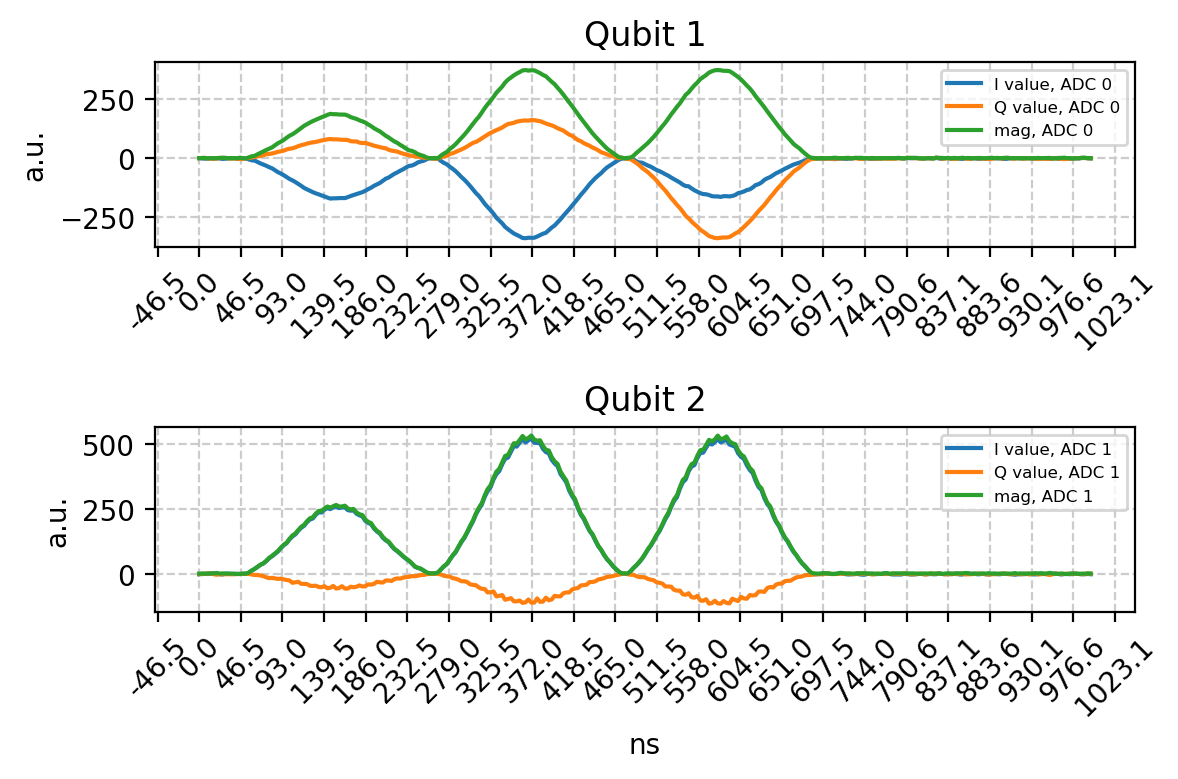

In [21]:
plot_2q(iq_lists)

## The qubit drive pulse amplitude sets the angular velocity on the Bloch sphere. How much will the qubit rotate on the Bloch sphere during the pulse?

A X/2 (or Y/2) gate it will rotate the qubit by 90 degrees around its Bloch sphere. A X (or Y) gate will rotate the qubit by 180 degrees around its Bloch sphere.

Lets change the gate sequence to do some X and X/2, Y and Y/2 gates on the qubits. 

See the Quirk circuit equivalent https://algassert.com/quirk#circuit={%22cols%22:[[%22Y^%C2%BD%22,%22X^%C2%BD%22],[%22Y%22,%22X%22],[%22X%22,%22X%22],[%22Y^-%C2%BD%22,%22X^%C2%BD%22],[1,%22X^%C2%BD%22],[%22X%22,%22X^-%C2%BD%22]]} to see where the qubits end up on the Bloch sphere! 

Notice the difference between a Y/2 and -Y/2 (or X/2 and -X/2) gate. Notice what the I gate does (nothing! Its is represented by the identity matrix).

In [22]:
q1_pulse_freq = 2000 
q1_read_freq = 2000
q2_pulse_freq = 2100 
q2_read_freq = 2100
pi_sigma_us = 0.03

config = {"q1_ch": 0,  # --Fixed
          "q2_ch": 2,
          "q1_ro_ch": 0,
          "q2_ro_ch": 1,
          "ro_chs": [0,1],
          "reps": 1,  # --Fixed
          "relax_delay": 1.0,  # --us
          "res_phase": 0,  # --degrees
          "pulse_style": "arb",  # --Fixed
          "pi_sigma": soc.us2cycles(pi_sigma_us,gen_ch=2),
          "readout_length": soc.us2cycles(1,ro_ch=0),  # [Clock ticks]
          "pi_gain": 30000,  # [DAC units]
          "pi_2_gain": 15000,
          "q1_pulse_freq": q1_pulse_freq,  # [MHz]
          "q2_pulse_freq": q2_pulse_freq,  # [MHz]
          "q1_read_freq": q1_read_freq,
          "q2_read_freq": q2_read_freq,
          "adc_trig_offset": soc.us2cycles(0.52,ro_ch=0),  # [Clock ticks]
          "soft_avgs": 1,
          "expts": 1
          }

config["gate_set"] = generate_2qgateset(config)

### We change this!
config['gate_seq'] = [{'Q1': 'Y/2', 'Q2': 'X/2'}, {'Q1': 'Y', 'Q2': 'X'},
                      {'Q1': 'X', 'Q2': 'X'}, {'Q1': '-Y/2', 'Q2': 'X/2'},
                      {'Q1': 'I', 'Q2': 'X/2'},{'Q1': 'X', 'Q2': '-X/2'}]

print(config['gate_seq'])

[{'Q1': 'Y/2', 'Q2': 'X/2'}, {'Q1': 'Y', 'Q2': 'X'}, {'Q1': 'X', 'Q2': 'X'}, {'Q1': '-Y/2', 'Q2': 'X/2'}, {'Q1': 'I', 'Q2': 'X/2'}, {'Q1': 'X', 'Q2': '-X/2'}]


In [23]:
prog = PulseSequence(soccfg, config)
# print(prog)
iq_lists = []
# print(self.cfg)
soc.reset_gens()  # clear any DC or periodic values on generators
iq_list = prog.acquire_decimated(soc, load_pulses=True, progress=False, debug=False)
iq_lists.append(iq_list)

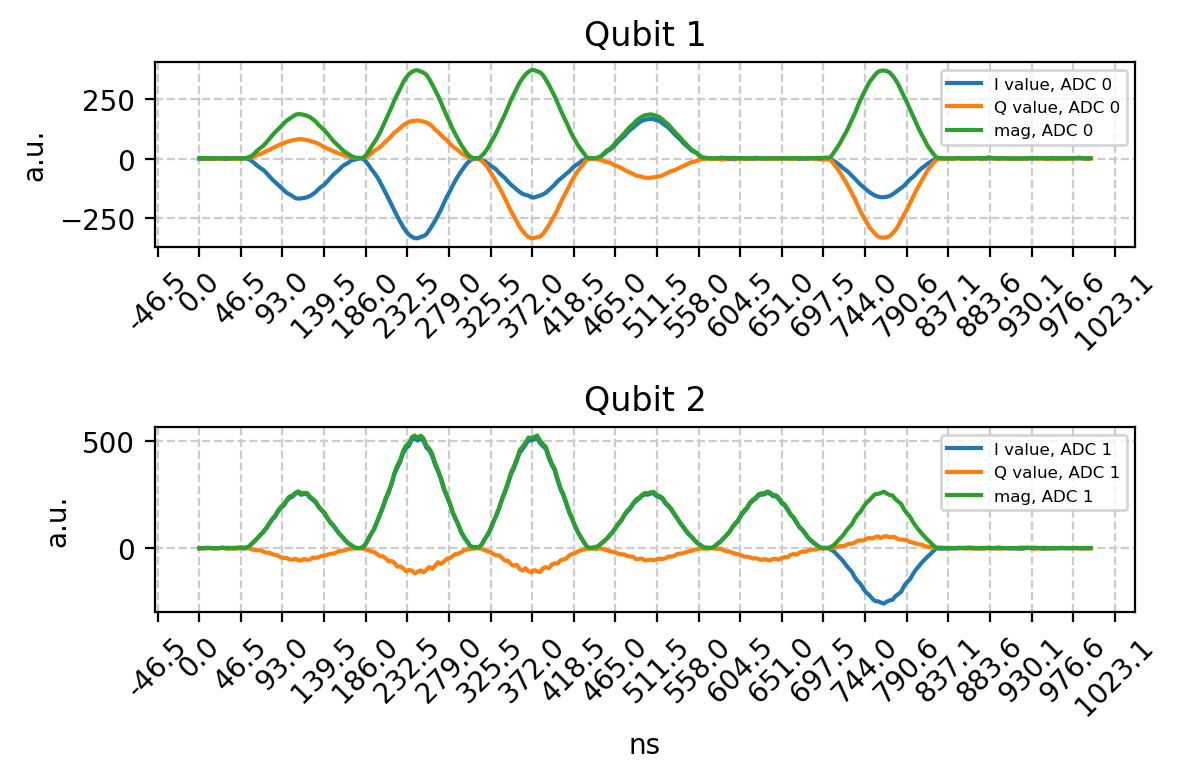

In [24]:
plot_2q(iq_lists)

## Multiple X gates and virtual-Z gates

If you have multiple X gates, they all need to match the qubit’s reference phase (phase coherence); you need to track the reference phase to define your X, Y, virtual-Z

For the Z gates (virtual rotation), we need to advance the phase of all the pulses which follow afterwards.

Notice what happens when we applied virtual-Z gates in this example!

In [25]:
q1_pulse_freq = 2000 
q1_read_freq = 2000
q2_pulse_freq = 2100 
q2_read_freq = 2100
pi_sigma_us = 0.03

config = {"q1_ch": 0,  # --Fixed
          "q2_ch": 2,
          "q1_ro_ch": 0,
          "q2_ro_ch": 1,
          "ro_chs": [0,1],
          "reps": 1,  # --Fixed
          "relax_delay": 1.0,  # --us
          "res_phase": 0,  # --degrees
          "pulse_style": "arb",  # --Fixed
          "pi_sigma": soc.us2cycles(pi_sigma_us,gen_ch=2),
          "readout_length": soc.us2cycles(1,ro_ch=0),  # [Clock ticks]
          "pi_gain": 30000,  # [DAC units]
          "pi_2_gain": 15000,
          "q1_pulse_freq": q1_pulse_freq,  # [MHz]
          "q2_pulse_freq": q2_pulse_freq,  # [MHz]
          "q1_read_freq": q1_read_freq,
          "q2_read_freq": q2_read_freq,
          "adc_trig_offset": soc.us2cycles(0.52,ro_ch=0),  # [Clock ticks]
          "soft_avgs": 1,
          "expts": 1
          }

config["gate_set"] = generate_2qgateset(config)

### We change this!
config['gate_seq'] = [{'Q1': 'X', 'Q2': 'X'}, {'Q1': 'Z', 'Q2': 'Z'},
                      {'Q1': 'X', 'Q2': 'X'}]

print(config['gate_seq'])

[{'Q1': 'X', 'Q2': 'X'}, {'Q1': 'Z', 'Q2': 'Z'}, {'Q1': 'X', 'Q2': 'X'}]


In [26]:
prog = PulseSequence(soccfg, config)
# print(prog)
iq_lists = []
# print(self.cfg)
soc.reset_gens()  # clear any DC or periodic values on generators
iq_list = prog.acquire_decimated(soc, load_pulses=True, progress=False, debug=False)
iq_lists.append(iq_list)

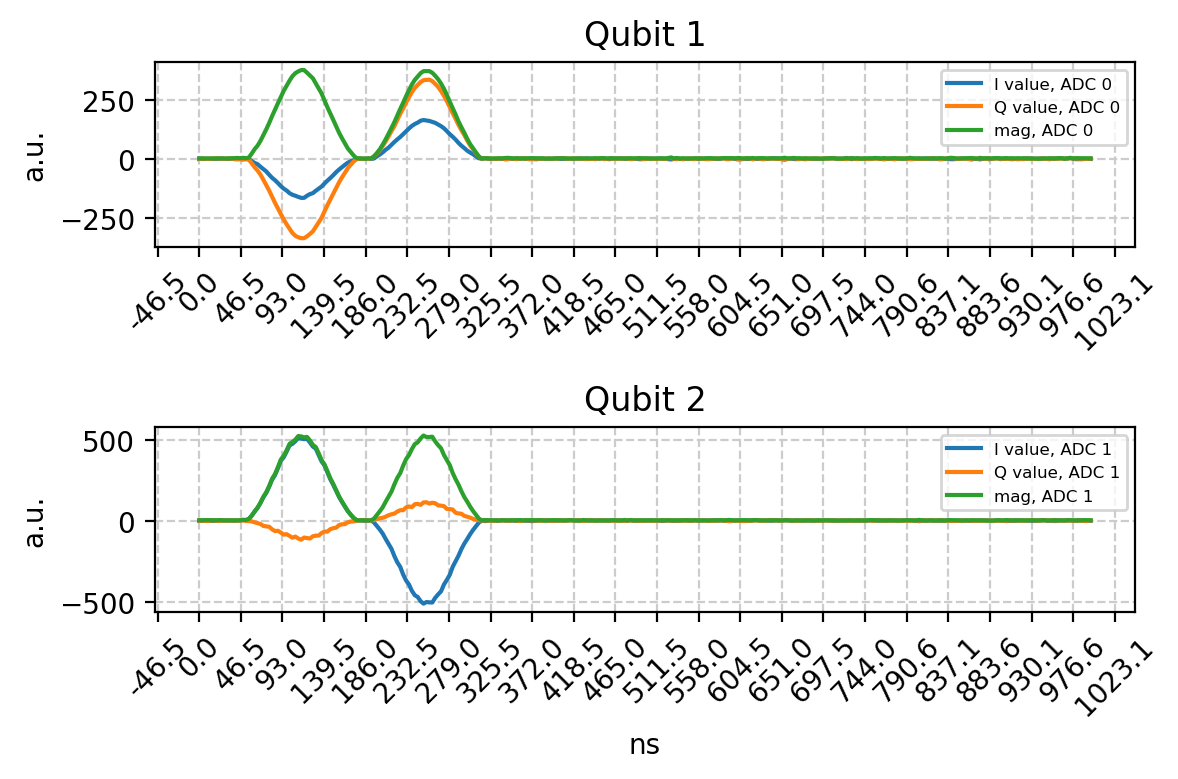

In [27]:
plot_2q(iq_lists)

## Quantum state characterization and qubit gate benchmarking

In general you want to do long pulse sequences for quantum state characterization and qubit gate benchmarking experiments, like in this paper, where 2 qubit randomized benchmarking and 2 qubit state and process tomography was done with the QICK: https://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.5.020326

We are loading the gate sequence from a pickle file this time, where it has been stored ahead of time. The gates are the 16 preparation basis gates for two-qubit process tomography.

In [28]:
q1_pulse_freq = 2000 
q1_read_freq = 2000
q2_pulse_freq = 2100 
q2_read_freq = 2100
pi_sigma_us = 0.01

config = {"q1_ch": 0,  # --Fixed
          "q2_ch": 2,
          "q1_ro_ch": 0,
          "q2_ro_ch": 1,
          "ro_chs": [0,1],
          "reps": 1,  # --Fixed
          "relax_delay": 1.0,  # --us
          "res_phase": 0,  # --degrees
          "pulse_style": "arb",  # --Fixed
          "pi_sigma": soc.us2cycles(pi_sigma_us,gen_ch=2),
          "readout_length": soc.us2cycles(1,ro_ch=0),  # [Clock ticks]
          "pi_gain": 30000,  # [DAC units]
          "pi_2_gain": 15000,
          "q1_pulse_freq": q1_pulse_freq,  # [MHz]
          "q2_pulse_freq": q2_pulse_freq,  # [MHz]
          "q1_read_freq": q1_read_freq,
          "q2_read_freq": q2_read_freq,
          "adc_trig_offset": soc.us2cycles(0.52,ro_ch=0),  # [Clock ticks]
          "soft_avgs": 1,
          "expts": 1
          }

config["gate_set"] = generate_2qgateset(config)

### We change this!
with open('prep_moments.pkl', 'rb') as f:
    prep_moments = pickle.load(f)

config['gate_seq'] = prep_moments
print(config['gate_seq'])

[{'Q1': 'I', 'Q2': 'I', 'C': 'I'}, {'Q1': 'I', 'Q2': 'X', 'C': 'I'}, {'Q1': 'I', 'Q2': 'Y/2', 'C': 'I'}, {'Q1': 'I', 'Q2': '-X/2', 'C': 'I'}, {'Q1': 'X', 'Q2': 'I', 'C': 'I'}, {'Q1': 'X', 'Q2': 'X', 'C': 'I'}, {'Q1': 'X', 'Q2': 'Y/2', 'C': 'I'}, {'Q1': 'X', 'Q2': '-X/2', 'C': 'I'}, {'Q1': 'Y/2', 'Q2': 'I', 'C': 'I'}, {'Q1': 'Y/2', 'Q2': 'X', 'C': 'I'}, {'Q1': 'Y/2', 'Q2': 'Y/2', 'C': 'I'}, {'Q1': 'Y/2', 'Q2': '-X/2', 'C': 'I'}, {'Q1': '-X/2', 'Q2': 'I', 'C': 'I'}, {'Q1': '-X/2', 'Q2': 'X', 'C': 'I'}, {'Q1': '-X/2', 'Q2': 'Y/2', 'C': 'I'}, {'Q1': '-X/2', 'Q2': '-X/2', 'C': 'I'}]


In [29]:
prog = PulseSequence(soccfg, config)
# print(prog)
iq_lists = []
# print(self.cfg)
soc.reset_gens()  # clear any DC or periodic values on generators
iq_list = prog.acquire_decimated(soc, load_pulses=True, progress=False, debug=False)
iq_lists.append(iq_list)

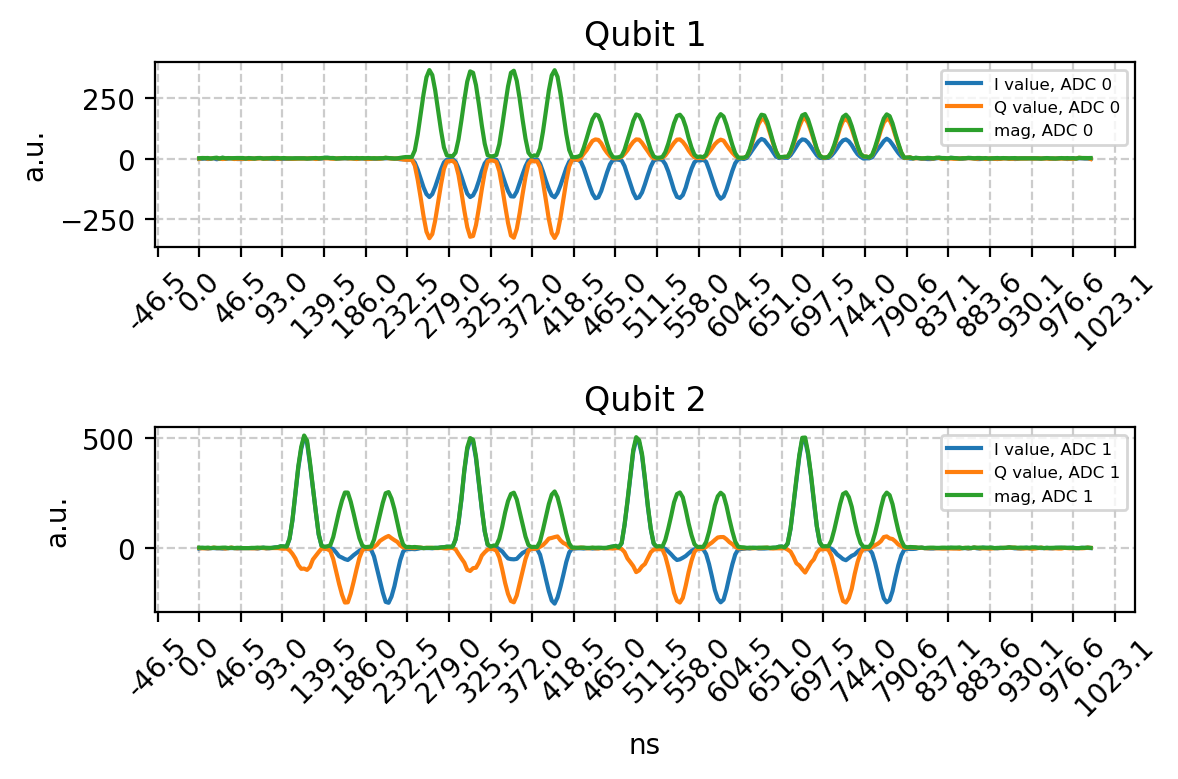

In [30]:
plot_2q(iq_lists)